In [71]:
import pandas as pd
import altair as alt
from altair import datum

## Read in library web site page views data


In [72]:
pageviews = pd.read_csv('pageviews_2012_ncsubset_wlatlon.csv')
pageviews.head()

,timestamp,lcc_first_letter,lcc_category,visitors,city,region,country,longitude,latitude
0,2012-01-01 17:00:00,P,PN,1,Pleasanton,California,United States,-121.8747,37.6624
1,2012-01-01 17:00:00,P,PN,1,Oklahoma City,Oklahoma,United States,-97.5164,35.4676
2,2012-01-01 11:00:00,P,PN,1,Durham,North Carolina,United States,-78.8986,35.9940
3,2012-01-01 11:00:00,E,E,1,Durham,North Carolina,United States,-78.8986,35.9940
4,2012-01-01 13:00:00,F,F,1,Durham,North Carolina,United States,-78.8986,35.9940


In [73]:
len(pageviews)

196667

In [74]:
pageviews.dtypes

timestamp            object
lcc_first_letter     object
lcc_category         object
visitors              int64
city                 object
region               object
country              object
longitude           float64
latitude            float64
dtype: object

## Change ISO_time to a true date and time data type

In [75]:
pageviews['timestamp'] = pd.to_datetime(pageviews.timestamp)
pageviews.dtypes

timestamp           datetime64[ns]
lcc_first_letter            object
lcc_category                object
visitors                     int64
city                        object
region                      object
country                     object
longitude                  float64
latitude                   float64
dtype: object

## MaxRowsError

Can take off limit for number of rows, but that's not a great idea because the notebook will have a Vega-Lite JSON specification (text) embedded for every output pane, which also includes the data, so you end up with huge notebooks!

Instead, we can specify that the outputs should just refer to a JSON file on your local drive and load in the data from there for each plot.

See the Altair tutorial notebook `03-Binning-and-aggregation` for more details.

In [76]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Visitors continuous time line

#### A sum of visitors per day shows some weekly and seasonal detail

[timeunit valid entries](https://altair-viz.github.io/user_guide/transform.html#timeunit-transform) are listed within a type of data transform called a **TimeUnit Transform**

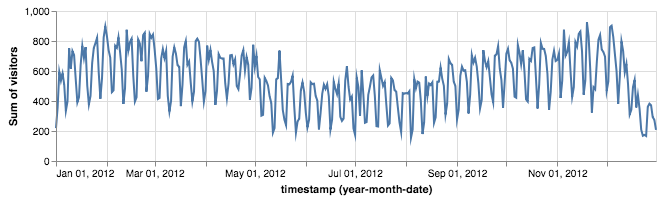

In [96]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonthdate(timestamp):T',
    y = 'sum(visitors):Q',
    tooltip = 'yearmonthdate(timestamp):T'
).properties(
    width=600,
    height=150
)

#### You can see the school holidays clearly in the Durham pageviews

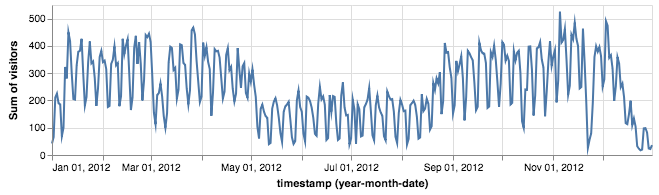

In [78]:
alt.Chart(pageviews).mark_line().encode(
    x = 'yearmonthdate(timestamp):T',
    y = 'sum(visitors):Q',
    tooltip = 'yearmonthdate(timestamp):T'
).transform_filter(
    datum.city == 'Durham'
).properties(
    width=600,
    height=150
)

## Visitors by hour of day

[timeunit valid entries](https://altair-viz.github.io/user_guide/transform.html#timeunit-transform)

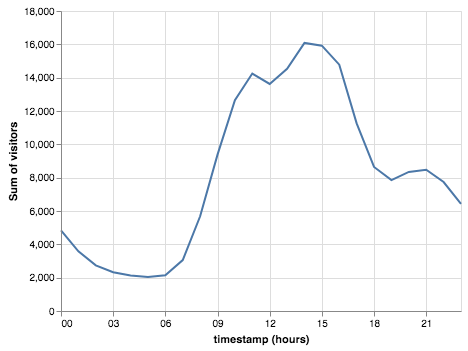

In [79]:
alt.Chart(pageviews).mark_line().encode(
    x= 'hours(timestamp):T',
    y = 'sum(visitors):Q'
)

#### Doing aggregation using Pandas instead

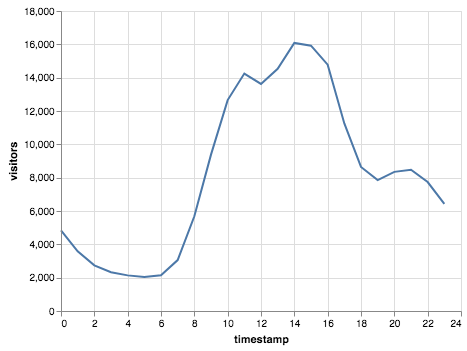

In [95]:
per_hour_of_day = pageviews.groupby(pageviews.timestamp.dt.hour).sum().reset_index()

alt.Chart(per_hour_of_day).mark_line().encode(
    x= 'timestamp:Q',
    y = 'visitors:Q'
)

## Weekday vs hour of day heatmap

*Notice here that we change from a Time data type to Ordinal to get discreet marks*

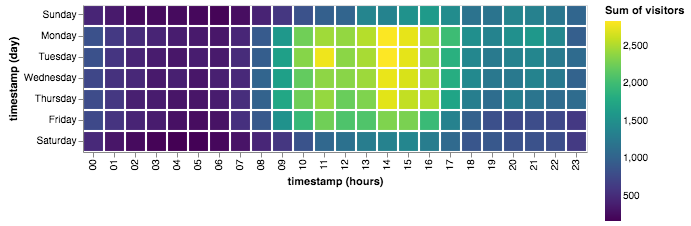

In [81]:
alt.Chart(pageviews).mark_rect().encode(
    x= 'hours(timestamp):O',
    y= 'day(timestamp):O',
    color='sum(visitors)'
)

## Canada, UK China time shift

### with Altair doing the filtering

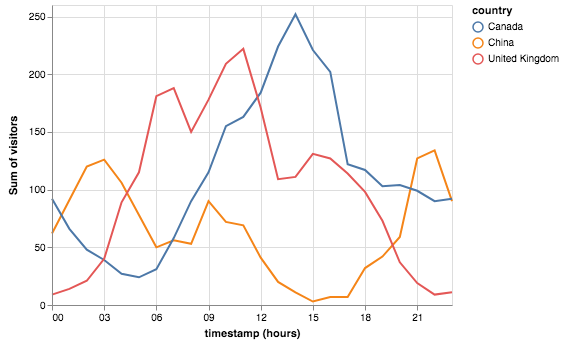

In [82]:
alt.Chart(pageviews).mark_line().encode(
    x = 'hours(timestamp):T',
    y = 'sum(visitors):Q',
    color = 'country'
).transform_filter(
    (datum.country == 'Canada') | \
    (datum.country == 'United Kingdom') | \
    (datum.country == 'China')
)

### with Pandas doing the filtering

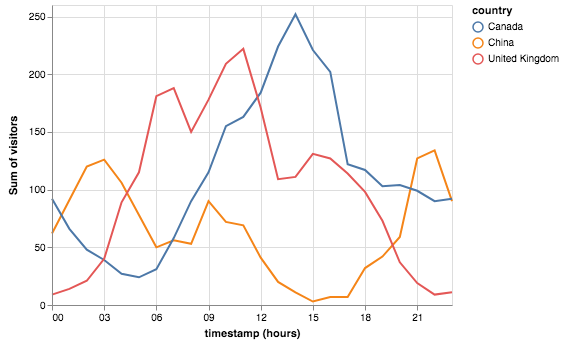

In [83]:
cauk = pageviews.loc[(pageviews.country == 'Canada') | \
                     (pageviews.country == 'United Kingdom') | \
                     (pageviews.country == 'China')]

alt.Chart(cauk).mark_line().encode(
    x = 'hours(timestamp):T',
    y = 'sum(visitors):Q',
    color = 'country'
)

## Map visitors per country without NC results

In [84]:
from vega_datasets import data

In [85]:
countries = alt.topo_feature(data.world_110m.url, feature='countries')
latlon = pd.read_csv('average-latitude-longitude-countries.csv')
latlon.head()

,ISO 3166 Country Code,Country,Latitude,Longitude
0,AD,Andorra,42.50,1.50
1,AE,United Arab Emirates,24.00,54.00
2,AF,Afghanistan,33.00,65.00
3,AG,Antigua and Barbuda,17.05,-61.80
4,AI,Anguilla,18.25,-63.17


## Visitors per country (excluding US) symbol map

### Doing aggregation, filtering and data join within Altair

For some data sources (e.g. data available at a URL, or data that is streaming), it is desirable to have a means of joining data without having to download it for pre-processing in Pandas.

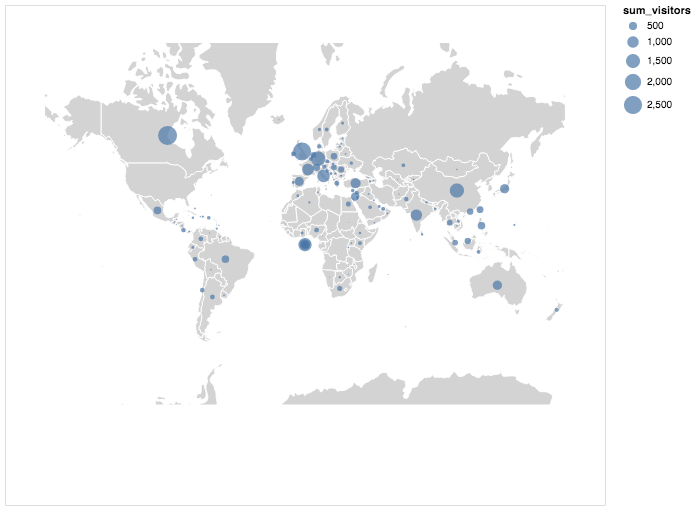

In [86]:
proj_type = 'mercator'
width = 600
height = 500
clip_extent = [[0,0.075*height],[width,0.8*height]]

background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    type=proj_type,
    clipExtent=clip_extent
).properties(
    width=width,
    height=height
)

points = alt.Chart(pageviews).mark_circle().encode(
    longitude = 'Longitude:Q',
    latitude = 'Latitude:Q',
    size = 'sum_visitors:Q',
    tooltip = 'country'
).transform_filter(
    datum.country != 'United States'
).transform_aggregate(
    sum_visitors='sum(visitors)',
    groupby=['country']
).transform_lookup(
    lookup = "country",
    from_ = alt.LookupData(data=latlon, key='Country', fields=['Latitude','Longitude'])
).project(
    type=proj_type,
    clipExtent=clip_extent
).properties(
    width=width,
    height=height
)

background + points

## Map after Pandas aggregation and merge with Lat/Lon

In [87]:
no_us = pageviews.loc[pageviews.country != 'United States']


In [88]:
no_us_country = no_us.groupby('country').agg({'visitors':'sum', 
                         'longitude':'mean', 
                         'latitude':'mean'}).reset_index()
no_us_country.head()

,country,visitors,longitude,latitude
0,(not set),818,0.000000,0.000000
1,Afghanistan,13,69.171700,34.528500
2,Albania,14,19.831800,41.331600
3,Algeria,37,3.374911,36.108903
4,Angola,1,13.237500,-8.813500


In [89]:
no_us_country_latlon = pd.merge(no_us_country, latlon, how='left',
                               left_on='country', right_on='Country')
no_us_country_latlon.head()

,country,visitors,longitude,latitude,ISO 3166 Country Code,Country,Latitude,Longitude
0,(not set),818,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Afghanistan,13,69.171700,34.528500,AF,Afghanistan,33.0,65.0
2,Albania,14,19.831800,41.331600,AL,Albania,41.0,20.0
3,Algeria,37,3.374911,36.108903,DZ,Algeria,28.0,3.0
4,Angola,1,13.237500,-8.813500,AO,Angola,-12.5,18.5


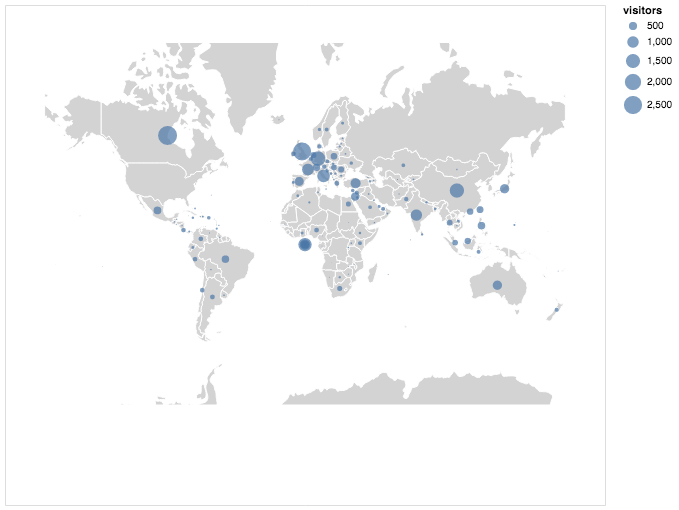

In [90]:
proj_type = 'mercator'
width = 600
height = 500
clip_extent = [[0,0.075*height],[width,0.8*height]]

background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(type = proj_type, 
          clipExtent = clip_extent
).properties(
    width = width,
    height = height
)

points = alt.Chart(no_us_country_latlon).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size='visitors:Q',
    tooltip=alt.Tooltip(['country:O', 'visitors:Q'])
).project(
    type = proj_type, 
    clipExtent= clip_extent
).properties(
    width = width,
    height = height
)

background + points

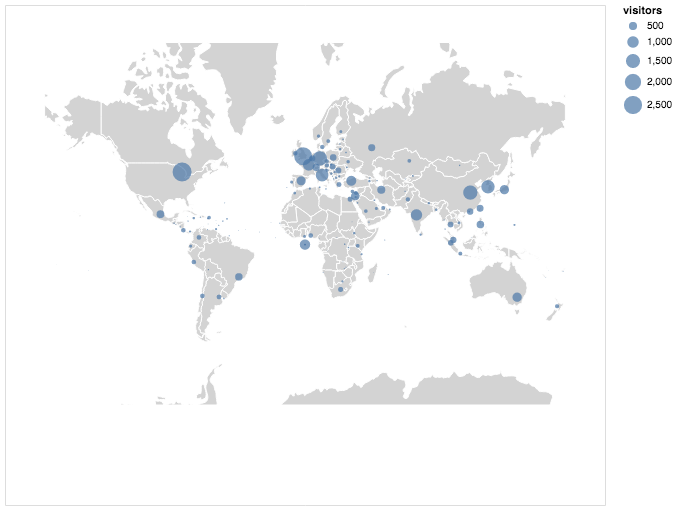

In [91]:
proj_type = 'mercator'
width = 600
height = 500
clip_extent = [[0,0.075*height],[width,0.8*height]]

background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(type = proj_type, 
          clipExtent = clip_extent
).properties(
    width = width,
    height = height
)

points = alt.Chart(no_us_country_latlon).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size='visitors:Q',
    tooltip=alt.Tooltip(['country:O', 'visitors:Q'])
).project(
    type = proj_type, 
    clipExtent= clip_extent
).properties(
    width = width,
    height = height
)

background + points

### Map of non-NC world cities

Aggregation and filtering in Pandas

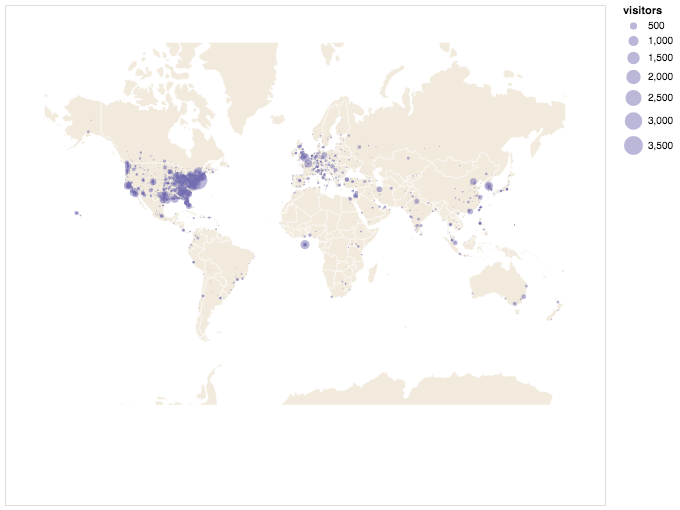

In [92]:
no_nc = pageviews.loc[pageviews.region != 'North Carolina']

no_nc_city = no_nc.groupby(['country','region','city']).agg({'visitors':'sum', 
                         'longitude':'mean', 
                         'latitude':'mean'}).reset_index()

proj_type = 'mercator'
width = 600
height = 500
clip_extent = [[0,0.075*height],[width,0.8*height]]

background = alt.Chart(countries).mark_geoshape(
    fill='#e5d8bd',
    stroke='white',
    opacity=0.5
).project(type = proj_type, 
          clipExtent = clip_extent
).properties(
    width = width,
    height = height
)

points = alt.Chart(no_nc_city).mark_circle(
    opacity = 0.5,
    color = '#7570b3'
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size='visitors:Q',
    tooltip=alt.Tooltip(['country:N', 'region:N', 'city:N', 'visitors:Q']),
).project(
    type = proj_type, 
    clipExtent= clip_extent
).properties(
    width = width,
    height = height
)

background + points

### Map of non-NC US cities

Aggregation and filtering in Altair

*Note that with groupby you need to do all of your aggregation in the transform_aggregate() section!*

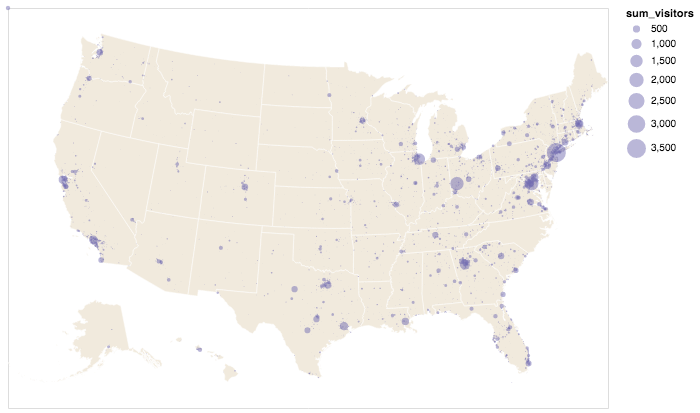

In [93]:
states = alt.topo_feature(data.us_10m.url, 'states')
proj_type = 'albersUsa'
width = 600
height = 400

background = alt.Chart(states).mark_geoshape(
    fill='#e5d8bd',
    stroke='white',
    opacity=0.5
).project(
    type = proj_type
).properties(
    width = width,
    height = height
)

points = alt.Chart(pageviews).mark_circle(
    opacity = 0.5,
    color = '#7570b3'
).encode(
    longitude = 'mean_longitude:Q',
    latitude = 'mean_latitude:Q',
    size = 'sum_visitors:Q',
    tooltip=alt.Tooltip(['region:N', 'city:N', 'sum_visitors:Q']),
).transform_filter(
    (datum.country == 'United States') & (datum.region != 'North Carolina')
).transform_aggregate(
    sum_visitors = 'sum(visitors)',
    mean_longitude = 'mean(longitude)',
    mean_latitude = 'mean(latitude)',
    groupby=['country','region','city']
).project(
    type = proj_type
).properties(
    width = width,
    height = height
)

background + points

### Map of non-NC US cities

Aggregation and filtering in Pandas

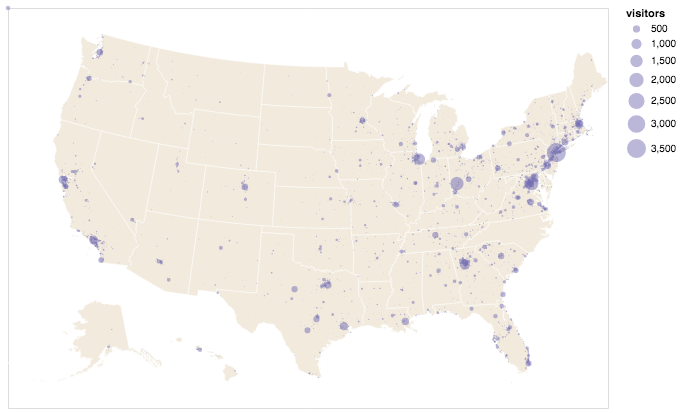

In [94]:
states = alt.topo_feature(data.us_10m.url, 'states')
proj_type = 'albersUsa'
width = 600
height = 400

background = alt.Chart(states).mark_geoshape(
    fill='#e5d8bd',
    stroke='white',
    opacity=0.5
).project(
    type = proj_type
).properties(
    width = width,
    height = height
)

no_nc_usa_city = no_nc_city.loc[no_nc_city.country == 'United States']

points = alt.Chart(no_nc_usa_city).mark_circle(
    opacity = 0.5,
    color = '#7570b3'
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size='visitors:Q',
    tooltip=alt.Tooltip(['region:N', 'city:N', 'visitors:Q']),
).project(
    type = proj_type
).properties(
    width = width,
    height = height
)

background + points